## Introduction
This notebook represents a comprehensive mathematical overview of diffusion models, starting from original DDPM up to latent diffusion models, including code for interaction with Stable Diffusion 1.5. The assumption is that the reader is familiar with prior generative modelling paradigms like VAE, GAN, and modern neural network architectures like transformers.

## DDPM - Denoising Diffusion Probabilistic Models
Original paper: https://arxiv.org/pdf/2006.11239

Let $D = \{X_{i}\}_{i=1}^{N}$ be the input dataset, $X_i \in \mathbb{R^{n}}$, and let $X_i \sim q_0$ be the true data distribution. Diffusion models are a family of generative models, that try to model the distribution $q_0$. For a given data point $x_0$ and given (fixed) number of time steps $T$, we first define **forward diffusion process**, given by the following Markov chain:

$$
\begin{equation*}
\begin{split}
    & q(x_{1:T} \mid x_0) = \prod_{s=1}^{T}q(x_t \mid x_{t - 1}) \\
    & q(x_{t} \mid x_{t - 1}) \sim \mathcal{N}(\sqrt{1 - \beta_{t}} x_{t - 1}, \beta_{t} I)
\end{split}
\end{equation*}
$$

$x_{1:T} = (x_{1}, \ldots, x_{T})$ are noisy versions of our starting image, with $x_{T}$ being the "most" noisy representation. Essentially, we start from a "clean" data point $x_0$, and iteratively add Gaussian noise to it until it is unrecognizible. $\{\beta_{t}\}_{t = 1}^{T}, \beta_{i} \in [0, 1]$ parameters define mean/variance schedules. Typically, $\beta_{1} < \ldots < \beta_{T}$, because we can afford having higher variance in later steps - the image is already distorted significantly. In particular, for the DDPM paper, authors chose $T = 1000, \beta_{1} = 1e-4, \beta_{T} = 0.02$, and applied simple linear scheduling for the rest of $\beta$ values. Given the nice properties of Gaussians, and the fact that we iteratively apply Gaussian noise to the given input image, it should not come as a surprise that we can sample $x_{t}$ for arbitrary $t$, without needing to compute $x_{t - 1}$ and other previous iterations. It can be shown that:
$$
x_{t} = \sqrt{\overline{\alpha_{t}}}x_{0} + \sqrt{1 - \overline{\alpha_{t}}} \epsilon
$$

where $\epsilon \sim \mathcal{N}(0, I)$, and $\alpha_{t} = 1 - \beta_{t}, \overline{\alpha_{t}} = \prod_{i=1}^{t}\alpha_{t}$. It is clear that $x_{T}$ converges to unit Gaussian, as $T \rightarrow \infty$.

The goal of diffusion models is to model the **reverse diffusion process**, $q(x_{t - 1} \mid x_{t})$. If we could do this, we can start from $x_{T} \sim \mathcal{N}(0, I)$, and then apply the reverse diffusion process $T$ times, reconstructing the original image. It can be shown that the reverse diffusion process is tractable, when conditioned on the original data point from the forward process. Namely:
$$
\begin{equation*}
\begin{split}
    & q(x_{t - 1} \mid x_{t}, x_{0}) \sim \mathcal{N}(\widetilde{\mu}(x_{t}, t), \widetilde{\beta_t}I) \\
    & \widetilde{\mu}(x_{t}, t) = \frac{1}{\sqrt{\alpha_{t}}}(x_{t} - \frac{1 - \alpha_{t}}{\sqrt{1 - \overline{\alpha_{t}}}}\epsilon) \\
    & \widetilde{\beta_t} = \frac{1 - \overline{\alpha_{t - 1}}}{1 - \overline{\alpha_{t}}} \beta_{t}
\end{split}
\end{equation*}
$$

However, during inference, we of course do not have access to $x_{0}$, and $q(x_{t - 1} \mid x_t)$ by itself is intractable. Computing $q(x_{t - 1} \mid x_t)$ would require us to use previous formula for $q(x_{t - 1} \mid x_t, x_0)$ while integrating over the data distribution, which is of course unknown. Diffusion models aim to approximate the reverse diffusion process, using the following parametric Markov chain:
$$
\begin{equation*}
\begin{split}
    & p_{\theta}(x_{0:T}) = p(x_{T}) \prod_{s=1}^{T} p_{\theta}(x_{t - 1} \mid x_{t}) \\
    & x_{T} \sim \mathcal{N}(0, I) \\
    & p_{\theta}(x_{t - 1} \mid x_{t}) \sim \mathcal{N}(\mu_{\theta}(x_t, t), \Sigma_{\theta}(x_t, t))
\end{split}
\end{equation*}
$$

Regarding $\Sigma_\theta(x_t, t)$, in DDPM the authors decided to fix this parameter to $\sigma_t^2I$, where $\sigma_t^2$ is an untrained constant, for every time step. Reasoning should be fairly obvious, if we consult the tractable expression for $q(x_{t - 1} | x_t, x_0)$, we can see that the covariance matrix is $\widetilde{\beta_t}I$. Authours experimented with both $\sigma_t^2 = \beta_t, \sigma_t^2 = \widetilde{\beta_t}$, and both approaches showed similar results. Later, we will see approaches that attempt to learn the covariance matrix as well. Notice that in this regime, the chosen $\beta_t$ schedule directly determines the schedule for $\sigma_t^2$.

![no figure](https://lilianweng.github.io/posts/2021-07-11-diffusion-models/DDPM.png)
*Illustration of the diffusion models workflow*

A reader that is familiar with VAEs (or variational inference in general) can notice that diffusion models can also be categorized as variational inference models. $x_{1:T} = (x_1, \ldots, x_{T})$ are latent vectors, albeit each $x_i$ is of the same dimensionality as the original data points, which is usually not the case in variational inference. The approximate forward process $p_{\theta}(x_{0} \mid x_{1:T})$ is our conditional data likelihood (conditioned on latent vectors of course), and $q(x_{1:T} \mid x_0)$ is the approximate posterior. Having said this, one can easily derive variational lower bound:
$$
-\mathbb{E}_{x_0 \sim q_0}[\log(p_\theta(x_0))] \leq \mathbb{E}_{x_0 \sim q_0, x_{1:T} \sim q(. \mid x_0)}[\log(\frac{q(x_{1:t} \mid x_0)}{p_{\theta}(x_{0:T})})] = L_{VLB}
$$

As usual in variational inference, maximizing the likelihood of our data boils down to maximizing the variational lower bound (or minimizing negative log likelihood boils down to minimizing negative variational bound). The previous expression can be expanded to the following:
$$
\mathbb{E}_{x_0 \sim q_0, x_{1:T} \sim q(. \mid x_0)}[\underbrace{D_{KL}[q(x_T \mid x_0) || p(x_T)]}_{L_T} + \sum_{t = 2}^{T}\underbrace{D_{KL}[q(x_{t - 1} \mid x_t, x_0) || p_\theta(x_{t - 1} \mid x_t)]}_{L_{t - 1}} - \underbrace{log(p_{\theta}(x_0 \mid x_1))}_{L_0}]
$$

Since $x_T \sim \mathcal{N}(0, I)$, and since per-step forward variances are not learnable, the term $L_T$ can be ignored during the optimization. $L_{t - 1}$ represents the KL divergence, which measures the discrepancy between the model's output distribution and tractable, true reverse diffusion distribution. Since both distributions are Gaussians, KL divergence can be expressed in closed form. $L_0$ represents the log-likelihood of true image $x_0$ given the first noisy iteration $x_1$. Since $p_\theta$ models a Gaussian distribution, and images come from a discrete space $\{0, \ldots, 255\}$, albeit normalized to $[-1, 1]$, the Gaussian is not able to produce this probability without some modifications because it is a continuous distribution. Intuitively, if we have a ground truth pixel $x \in [-1, 1]$, we would want our PDF to be high in some reasonably small neighborhoog of $x$. Authors of DDPM propose the following approach:
$$
\begin{equation*}
\begin{split}
    & p_\theta(x_0 \mid x_1) = \prod_{i=1}^{D} \int_{\delta_{-}(x_0^i)}^{\delta_{+}(x_0^i)}(\mathcal{N_{pdf}}(\mu_\theta^i(x_1, 1), \sigma_1^2))dx \\
    & \delta_{-}(x) = 
    \begin{cases} 
      -\infty & x = -1 \\
      x - \frac{1}{255}& x > -1
   \end{cases} \\
    & \delta_{+}(x) = 
    \begin{cases} 
      +\infty & x = 1 \\
      x + \frac{1}{255}& x < 1
   \end{cases}
\end{split}
\end{equation*}
$$

The $i$ superscript in previous equations corresponds to taking $i$-th data coordinate. The product in the first equation is justified by the diagonal covariance matrix. Since we can sample arbitrary $x_t$ for given $x_0$, authors propose optimizng the previous loss by randomly sampling data points and time steps, although they end up using a much simpler loss function in the end, as we will see soon. Regarding the integration of Gaussian PDF (or equivalently, evaluating the Gaussian CDF), we recall the following approximation used in practice: $\Phi(\frac{x - \mu}{\sigma}) = \frac{1}{2}(1 + erf(\frac{x - \mu}{\sqrt{2}\sigma})) \approx \frac{1}{2} (1 + tanh(\sqrt{\frac{2}{\pi}}(\frac{x - \mu}{\sigma} + 0.044715 (\frac{x - \mu}{\sigma})^3)))$

Somewhat surprisingly, it is sufficient for our model to predict added noise scaled to unit variance, at every time step. Recall that $\widetilde{\mu}(x_{t}, t) = \frac{1}{\sqrt{\alpha_{t}}}(x_{t} - \frac{1 - \alpha_{t}}{\sqrt{1 - \overline{\alpha_{t}}}}\epsilon)$. If we can model the noise added at time step $t$, we can easily reconstruct the unknown mean vector. What we actually end up with is:
\begin{equation*}
\begin{split}
    & \mu_\theta(x_t, t) = \frac{1}{\sqrt{\alpha_{t}}}(x_{t} - \frac{1 - \alpha_{t}}{\sqrt{1 - \overline{\alpha_{t}}}}\epsilon_\theta(x_t, t))
\end{split}
\end{equation*}

Incorporating this into $L_{t - 1}, 1 < t \leq T$ gives:
$$
L_{t - 1} = \mathbb{E}_{x_0 \sim q_0, \epsilon \sim \mathcal{N}(0, I)}[\frac{(1 - \alpha_t)^2}{2 \alpha_t (1 - \overline{\alpha_t}) \sigma_t^2)}||\epsilon - \epsilon_\theta(\sqrt{\overline{\alpha_t}}x_0 + \sqrt{1 - \overline{\alpha_t}}\epsilon, t)||_2^{2}] + C
$$

where $C$ is a constant term not depending on parameters $\theta$, and can be ignored during optimization.

The authors propose a simplified loss. First, they ignore all weighing terms for $L_{t - 1}$:

$$
L_{\text{simple}}(\theta) = \mathbb{E}_{x_0 \sim q_0, \epsilon \sim \mathcal{N}(0, I), t \sim \{1, \ldots, T\}}[||\epsilon - \epsilon_\theta(\underbrace{\sqrt{\overline{\alpha_t}}x_0 + \sqrt{1 - \overline{\alpha_t}}\epsilon}_{x_t}, t)||_2^{2}]
$$

Secondly, as we mentioned when introducing $L_{vlb}$, they sample random data points $x_0$ and random time steps $t \in [1, \ldots, T]$ and perform parameter update only from gradient of $L_{t - 1}$. The case $t = 1$ is related to $L_0$. However, they do not perform discretization of the Gaussian according to the final algorithm, instead they revert to noise prediction as with $t > 1$.

The training and sampling algorithms are given in the following pseudocode:
![no figure](https://lilianweng.github.io/posts/2021-07-11-diffusion-models/DDPM-algo.png)

## DDPM Forward Prop - Modified UNet
To predict noise from the given $x_t$, authors used a modified UNet, which incorporates multi-head attention and positional encodings - remember that $e_\theta(x_t, t)$, so we need to incorporate temporal information into the model as well. Details of the model architecture are not detailed in the paper, but I was able to reproduce this modified UNet architecture, you can find referrence repositories and forward prop implementation below.

I did not implement the training code, because the main goal of this section is to understand model's architecture, authors of the paper mention benchmark datasets (CelebAHQ, LSUN, CIFAR10, ...), optimization algorithms (AdamW, RMSProp) and chosen hyperparameters.

If you are not familiar with UNets, you can check out one of my notebooks abouts UNets: https://www.kaggle.com/code/lukautjesinovic/unet-image-segmentation

Some features of this modified UNet that I would like to highlight, that differ from traditional UNet:
* SiLU loss is used, $SiLU(x) = x \times \sigma(x)$, just a smooth approximation of ReLU, much like GeLU.
* Instead of Conv/BatchNorm/Relu layers in classical UNet, this version uses ResNet blocks.
* They use self-attention on pixel level. A single sequence is represented by all pixels accross all channels, sharing the same $(h, w)$ coordinates. With this representation of sequences, this attention mechanism is equivalent to transformers' self-attention mechanism, with $n_h = 1, d_k = C$, $C$ being the number of input channels. From here, one could easily extend this to multi-head attention by increasing $n_h$. Also, instead of layer normalization, this attention employs group normalization.
* As we have stated previously, temporal information needs to be injected into the model, $\epsilon_\theta(x_t, t)$. This is done with "timestep embeddings". Embeddings are constructed similarly to transformer positional embeddings - using sinusoids accross different input dimensions. Namely:

```
D - embedding dimension
half_dim = D // 2
time_pos[t, i] = sin(t / (10000)^(-i / (half_dim - 1)), for 0 <= i < half_dim
time_pos[t, i] = cos(t / (10000)^(-i / (half_dim - 1)), for half_dim <= i < D
If D is odd, zero pad last entry of the embedding.
```
* Notable difference is in the way these embeddings are propagated through the network. In classic transformer architecture, we add these embeddings with token embeddings in the very first layer. However, in this architecture, timestep embeddings are propagated to every ResNet block. Although they do explain not why this is done in the DDPM paper, I suspect that it is due to the necessity of modyfing individual ResNet block's behaviour, based on the denoising time step. In earlier timesteps, it would need to be more conservative with denoising as the original image is likely still visible, while in later steps it can more aggresively apply learned denoising strategy.
* These embeddings are initialized with dimensionality `D = 4 * init_channels`. Since ResNet operate on different channels, it is important to resize this embedding vector accordingly. They use a simple linear transformation, to reshape the timestep embeddings to the desired dimensionality, current number of input channels. After this is done, time embeddings are broadcasted channel-wise - to each spatial position of channel $i$, $time\_embedding[i]$ is added to it.

I also did not implement DDPM sampling algorithm, but it is fairly trivial, given the previous pseudocode. In one of later sections we will talk about sampling algorithms.

In [8]:
import torch
import math
import numpy as np
import torchvision

device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [9]:
# Gaussian DDPM Unet, based on following open-source implementations:
# https://github.com/hojonathanho/diffusion/tree/master - Repository tied to the official DDPM paper
# https://github.com/lucidrains/denoising-diffusion-pytorch
# https://nn.labml.ai/diffusion/ddpm/unet.html

class TimestepEmbedding(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, timestep, embedding_dim):
        half_dim = embedding_dim // 2
        emb = torch.tensor([math.log(10000) / (half_dim - 1)], device = timestep.device)
        emb = torch.exp(torch.arange(start = 0, end = half_dim, device = timestep.device) * -emb)
        emb = timestep[:, None] * emb[None, :]
        emb = torch.concat([torch.sin(emb), torch.cos(emb)], dim = 1)
        
        if embedding_dim % 2 == 1:
            emb = torch.nn.functional.pad(emb, (0, 1))
            
        return emb # [timestep.shape[0], embedding_dim]

class Upsample(torch.nn.Module):
    # Upsample by a factor of 2
    def __init__(self, in_channels, sample_conv = False):
        super().__init__()
        self.sample_conv = sample_conv

        if self.sample_conv:
            self.upsampler = torch.nn.ConvTranspose2d(in_channels, 
                                                      in_channels, 
                                                      kernel_size = 3, 
                                                      padding = 1, 
                                                      output_padding = 1, 
                                                      stride = 2)
    def forward(self, X):
        if self.sample_conv:
            return self.upsampler(X)

        else:
            return torchvision.transforms.functional.resize(X, [X.shape[-2] * 2, X.shape[-1] * 2], interpolation = torchvision.transforms.InterpolationMode.NEAREST)

class Downsample(torch.nn.Module):
    # Downsample by a factor of 2
    def __init__(self, in_channels, sample_conv = False):
        super().__init__()
        self.sample_conv = sample_conv

        if self.sample_conv:
            self.upsampler = torch.nn.Conv2d(in_channels, 
                                             in_channels, 
                                             kernel_size = 3, 
                                             padding = 1,
                                             stride = 2)
    def forward(self, X):
        if self.sample_conv:
            return self.upsampler(X)

        else:
            return torchvision.transforms.functional.resize(X, [X.shape[-2] // 2, X.shape[-1] // 2], interpolation = torchvision.transforms.InterpolationMode.NEAREST)

class ResNetBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels, time_channels, groups, dropout):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.time_channels = time_channels
        self.groups = groups
        self.dropout = dropout
        
        self.norm1 = torch.nn.GroupNorm(groups, in_channels, affine = True)
        self.conv1 = torch.nn.Conv2d(in_channels, out_channels, kernel_size = 3, padding = 1)
        self.act = torch.nn.SiLU()
        
        self.norm2 = torch.nn.GroupNorm(groups, out_channels, affine = True)
        self.conv2 = torch.nn.Conv2d(out_channels, out_channels, kernel_size = 3, padding = 1)

        self.time_emb = torch.nn.Linear(time_channels, out_channels)
        self.drp = torch.nn.Dropout(self.dropout)
        
        self.shortcut = torch.nn.Identity()
        if in_channels != out_channels:
            self.shortcut = torch.nn.Conv2d(in_channels, out_channels, kernel_size = 1)

    def forward(self, X):
        """
        Because of torch.nn.Sequential API, X is a tuple.
        X[0] is the current batch.
        X[1] are timestep embeddings.
        """

        X_data = X[0]
        timestep_embeddings = X[1]
        h = self.conv1(self.act(self.norm1(X_data)))
        # Timestep embeddings are reshaped according to current layer's output channels.
        # To the pixel of each channel, a corrsepodning timestep embedding cooridate is adedd.
        # This is how DDPM Gaussians UNets incoroprate temporal information.
        h += self.time_emb(self.act(timestep_embeddings))[:, :, None, None]
        h = self.conv2(self.drp(self.act(self.norm2(h))))
        return h + self.shortcut(X_data), timestep_embeddings

class AttentionBlock(torch.nn.Module):
    """
    Multi-head self-attention applied to pixels of each channel.
    Pixels are viewed as a column vector, by flattening to H * W.

    Obtained per-head mappings of size [B, W * H, num_heads * dk] are remapped to [B, C, H W] via 
    final linear transformation.
    """
    def __init__(self, in_channels, norm_groups, dropout):
        super().__init__()
        
        self.in_channels = in_channels
        # self.num_heads = num_heads
        self.norm_groups = norm_groups
        # self.dk = dk
        self.dropout = dropout
        
        self.gn = torch.nn.GroupNorm(norm_groups, in_channels, affine = True)
        self.WQ = torch.nn.Linear(in_channels, in_channels, bias = False)
        self.WK = torch.nn.Linear(in_channels, in_channels, bias = False)
        self.WV = torch.nn.Linear(in_channels, in_channels, bias = False)
        self.attention_out_map = torch.nn.Linear(in_channels, in_channels, bias = False)
        self.drp = torch.nn.Dropout(dropout)
        
        # self.attn_scale = dk ** -0.5
        self.attn_scale = self.in_channels ** -0.5

    def forward(self, X):
        """
        Because of torch.nn.Sequential API, X contains both the current batch and timestep embeddings,
        even though attention layers does not operate on timestep embeddings, so they are dsicarded here.
        """
        timestep_embeddings = X[1]
        X = X[0]
        B, C, H, W = X.shape

        Z = self.gn(X).view(B, C, -1).permute(0, 2, 1) # [B, seq, C]
        Q, K, V = self.WQ(Z), self.WK(Z), self.WV(Z) # [B, seq, C]
        attn_coeffs = torch.nn.functional.softmax(torch.matmul(Q, K.transpose(-1, -2)) * self.attn_scale, dim = -1) # [B, seq, seq]
        attn_coeffs = self.drp(attn_coeffs)
        out = attn_coeffs.matmul(V) # [B, seq, in_channels]
        out = self.attention_out_map(out).transpose(-2, -1).view(B, C, H, W) # [B, C, H, W]
        return out + X, timestep_embeddings

class DDPMUnet(torch.nn.Module):
    def __init__(self, in_channels, init_channels, group_norm_groups = 32, num_res_blocks = 1,
                 channel_mults = (1, 2, 4, 8), is_attn = [True, True, True, True], dropout = 0.7, sample_conv = True):
        
        super().__init__()
        self.in_channels = in_channels
        self.init_channels = init_channels
        self.group_norm_groups = group_norm_groups # Original implementation uses tf.contrib.layers.group_norm which defaults to 32 groups
        self.num_res_blocks = num_res_blocks
        self.channel_mults = channel_mults
        self.is_attn = is_attn
        self.dropout = dropout
        self.sample_conv = sample_conv
        
        self.te = TimestepEmbedding()
        self.silu = torch.nn.SiLU()

        # Starting layers
        self.init_conv = torch.nn.Conv2d(in_channels, init_channels, kernel_size = 3, padding = 1)
        self.te_mlp = torch.nn.Sequential(
            torch.nn.Linear(init_channels * 4, init_channels * 4),
            self.silu,
            torch.nn.Linear(init_channels * 4, init_channels * 4)
        )

        # Downsample part of UNet
        self.down_blocks = torch.nn.ModuleDict({
            f"resolution_mul_{resolution}": torch.nn.ModuleList([]) 
            for resolution in channel_mults
        })

        self.downsamplers = torch.nn.ModuleDict({
            f"resolution_mul_{resolution}": Downsample(init_channels * resolution, sample_conv = sample_conv)
            for resolution in channel_mults[:-1]
        })

        # Save number of output channels for every ResNet block in Downsampler, will be used when constructing upsampler
        # Start from input channels of first downsampler block.
        previous_channels = [init_channels] 
        prev_channels = init_channels * channel_mults[0]
        
        for i, channel_mul in enumerate(channel_mults):
            key = f"resolution_mul_{channel_mul}"
            for j in range(num_res_blocks):
                current = [ResNetBlock(prev_channels, channel_mul * init_channels, init_channels * 4, group_norm_groups, dropout)]
                prev_channels = init_channels * channel_mul
                previous_channels.append(channel_mul * init_channels)
                
                if is_attn[i]:
                    current.append(AttentionBlock(channel_mul * init_channels, group_norm_groups, dropout))
                    
                self.down_blocks[key].append(torch.nn.Sequential(*current))
                
            if key in self.downsamplers:
                previous_channels.append(channel_mul * init_channels)

            prev_mul = channel_mul
            
        # UNet Bottleneck
        self.middle_block = torch.nn.Sequential(
            ResNetBlock(channel_mults[-1] * init_channels, channel_mults[-1] * init_channels, init_channels * 4, group_norm_groups, dropout),
            AttentionBlock(channel_mults[-1] * init_channels, group_norm_groups, dropout),
            ResNetBlock(channel_mults[-1] * init_channels, channel_mults[-1] * init_channels, init_channels * 4, group_norm_groups, dropout)
        )

        # Upsample part of UNet
        self.up_blocks = torch.nn.ModuleDict({
            f"resolution_mul_{resolution}": torch.nn.ModuleList([]) 
            for resolution in channel_mults
        })

        self.upsamplers = torch.nn.ModuleDict({
            f"resolution_mul_{resolution}": Upsample(init_channels * resolution, sample_conv = sample_conv)
            for resolution in channel_mults[::-1][:-1]
        })

        prev_channels = init_channels * channel_mults[-1]
        
        for i, channel_mul in enumerate(channel_mults[::-1]):
            key = f"resolution_mul_{channel_mul}"
            # There are num_res_blocks + 1 ResNet blocks in a single Upsampler layer, because they incorporate initial downsapled
            # versions of feature maps in the skip connections.
            for j in range(num_res_blocks + 1):
                current = [ResNetBlock(prev_channels + previous_channels.pop(), channel_mul * init_channels, init_channels * 4, group_norm_groups, dropout)]
                if is_attn[i]:
                    current.append(AttentionBlock(channel_mul * init_channels, group_norm_groups, dropout))
                prev_channels = channel_mul * init_channels
                self.up_blocks[key].append(torch.nn.Sequential(*current))

        # End layer
        self.end_layer = torch.nn.Sequential(*(
            torch.nn.GroupNorm(group_norm_groups, init_channels, affine = True),
            torch.nn.SiLU(),
            torch.nn.Conv2d(init_channels, in_channels, kernel_size = 3, padding = 1)
        ))
        
    def forward(self, X, t):
        # X: [B, C, H, W]
        # t: [B]
        
        timestep_embeddings = self.te(t, self.init_channels * 4) # [B, in_channels * 4]
        timestep_embeddings = self.te_mlp(timestep_embeddings) # [B, in_channels * 4]
        hs = [(self.init_conv(X), "network_input")] # Starting point for Downsample portion of UNet

        # Downsampling portion
        for i, channel_mul in enumerate(self.channel_mults):
            key = f"resolution_mul_{channel_mul}"
            for j in range(len(self.down_blocks[key])):
                print(f"Downsampler block: {key}_down_block_{j}")
                print(f"Input shape: {hs[-1][0].shape}\n")
                h, _ = self.down_blocks[key][j]((hs[-1][0], timestep_embeddings))
                hs.append((h, f"{key}_down_block_{j}_out")) # Save for skip connections

            # Downsampling does not happen at the last downsampling block
            if key in self.downsamplers:
                # Downsampled versions also contribute to skip connections in upsampler part.
                hs.append((self.downsamplers[key](hs[-1][0]), f"{key}_downsampled")) 

        # Middle block
        h, _ = self.middle_block((hs[-1][0], timestep_embeddings))

        # Upsampling portion
        for i, channel_mul in enumerate(self.channel_mults[::-1]):
            key = f"resolution_mul_{channel_mul}"
            for j in range(len(self.up_blocks[key])):
                # Channel-wise concatenations in skip connections
                print(f"Upsampler block: {key}_up_block_{j}.")
                print(f"Input shape: {h.shape}.")
                print(f"Skip connection shape: {hs[-1][0].shape}.")
                print(f"Skip connection origin: {hs[-1][1]}.\n")
                h, _ = self.up_blocks[key][j]((torch.concat([h, hs.pop()[0]], dim = 1), timestep_embeddings))

            if key in self.upsamplers:
                h = self.upsamplers[key](h)
        # Should have exhausted all skip connections, otherwise raise and error!
        assert len(hs) == 0, f"Skip length is {len(hs)}"

        # Last layer
        return self.end_layer(h)
        
B = 4
C = 3
H = 128
W = 128
X = torch.rand(size = (B, C, H, W), device = device) # [0, 1]
X = 2 * X - 1 # Transform to [-1, 1]
timesteps = torch.randint(low = 1, high = 10001, size = (B,), device = device)

unet = DDPMUnet(3, 64, channel_mults = (1, 2, 4, 8), is_attn = [False, False, True, True], num_res_blocks = 3).to(device)
with torch.no_grad():
    pred = unet(X, timesteps)
    print(pred.shape)

Downsampler block: resolution_mul_1_down_block_0
Input shape: torch.Size([4, 64, 128, 128])

Downsampler block: resolution_mul_1_down_block_1
Input shape: torch.Size([4, 64, 128, 128])

Downsampler block: resolution_mul_1_down_block_2
Input shape: torch.Size([4, 64, 128, 128])

Downsampler block: resolution_mul_2_down_block_0
Input shape: torch.Size([4, 64, 64, 64])

Downsampler block: resolution_mul_2_down_block_1
Input shape: torch.Size([4, 128, 64, 64])

Downsampler block: resolution_mul_2_down_block_2
Input shape: torch.Size([4, 128, 64, 64])

Downsampler block: resolution_mul_4_down_block_0
Input shape: torch.Size([4, 128, 32, 32])

Downsampler block: resolution_mul_4_down_block_1
Input shape: torch.Size([4, 256, 32, 32])

Downsampler block: resolution_mul_4_down_block_2
Input shape: torch.Size([4, 256, 32, 32])

Downsampler block: resolution_mul_8_down_block_0
Input shape: torch.Size([4, 256, 16, 16])

Downsampler block: resolution_mul_8_down_block_1
Input shape: torch.Size([4, 5

**TODO: ADD DIAGRAM/COMPUTATIONAL GRAPH FOR THIS MODIFIED UNET ARCHITECTURE**

A term might pop up when investigating papers mentioned later in the notebook is **Adaptive Group Normalization**. DDPM adds timestep embeddings directly to hidden states in ResNet blocks, so in the next layer we have $GroupNorm(h + t)$. Adaptive group normalization instead projects input timestep embeddings to $2C$ - as opposed to $C$ when using the simple addition. This vector is then split into $w, b$, each having dimensionality of $C$. Finally, they are added to the hidden state using the following: $ADAGN(h, w, b) = GroupNorm(h) (w + 1) + b$. A small detial, but the reader might encounter it while exploring the improved DDPM repository. This is similar to Adaptive Instance normalization that is present in StyleGAN v1.

## Improved DDPM
Original paper: https://arxiv.org/pdf/2102.09672
While original DDPM model achieved FID comparable to other generative models at the time on various benchmarks, they were still not competitive with other generative models, with respect to the log-likelihood. Authors of IDDPM - Improved DDPM paper explore how to improve log-likelihood of DDPM models. They propose the following changes:

* Learnable covariance matrix. Instead of fixing $\Sigma_\theta(x_t, t) = \sigma_t^2 I$, they propose that learnable covariance matrix might improve log likelihood. They parameterize it as $\Sigma_\theta(x_t, t) = \exp(v log(\beta_t) + (1 - v) log\widetilde{\beta_t})$. $v$ are actually model outputs - in addition to predicting the added noise (mean), we predict additional parameter of same dimensionality as input. The above expression essentialy represents a per-component interpolation between $\widetilde{\beta_t}$ and $\beta_t$, representing the main diagonal of the covariance matrix. Do note that even though covariance matrix is diagonal now, the resulting distribution is not isotropic in general, because of components of vector $v$.
* Since $L_{simple}$ does not depend on variance, they introduce a new loss function: $L = L_{simple} + \lambda L_{vlb}$. To learn the mean, only gradients from $L_{simple}$ are used, and to learn the variance only gradients from $L_{vlb}$ are used. Of course, $L_{vlb}$ depends on the distribution mean as well, as we can see in the DDPM section, but gradients for the mean are zeroed-out for this part of the loss. They use $\lambda = 1e-3$, to avoid $L_{vlb}$ overwhelming the noise reconstruction loss.
* Different $\beta_t$ schedule. Essentially, authors reason that later stages of the forward process with linear scheduling (chosen variance schedule in original DDPM) produce very noisy images, and do not contribute much to the final sample quality. Instead, the opt to smooth-out the variance schedule curve, keeping variances near-constant near $t = 0, t = T$, while having a near-linear schedule during the middle stages of the forward process. The chose the following schedule:

$$
\overline{\alpha_t} = \frac{f(t)}{f(0)}, f(t) = cos^2(\frac{tT^{-1} + s}{1 + s} + \frac{\pi}{2})
$$

where $s$ is an offset selected to prevent $\beta_t$ to be small when $t$ is close to 0. Note that the previous epxression schedules $\overline{\alpha_t}$, but if we recall the definition of $\overline{\alpha_t}$ in terms of $\beta_t$, one can easily derive $\beta_t$. Also, they propose to clip $\beta_t$ values to 0.999 in practice.

![no figure](https://lilianweng.github.io/posts/2021-07-11-diffusion-models/diffusion-beta.png)

* They also experiment with optimizing $L_{vlb}$ and $L_{hybrid}$. It turns out that both loss functions produce noisy log likelihoods on the given datasets during training, but $L_{hybrid}$ achieves better log-likelihood. To reduce the variance of $L_{vlb}$ during training, they incorporate importance sampling. Recall that in the original DDPM paper, authors discuss training both $L_{vlb}$ and $L_{simple}$ by randomly sampling $L_{t - 1}$. Improved DDPM starts with the same approach, they start sampling $t \sim U[1, \ldots, T]$ until 10 samples from each time steps are sampled. Then, they estimate second moment for every $L_{t - 1}, \mathbb{E}[L_{t - 1}^2]$, and they use these estimates as weights for importance sampling, essentially meaning that timesteps with higher second moment are more likely to be sampled. This significantly improves the training stability.
* Lastly, they quadruple the number of diffusion steps during training, with respect to DDPM's original $T = 1000$, they use $T = 4000$, and with previous modifications, they achieve much better log-likelihood.

Authors also propose a method for increasing inference/sampling speed. First, they choose subsequence of timesteps $S$, typically evenly spaced integers from set $[1, \ldots, T]$ of desired size. Then, they consult the chosen sampling schedule to obtain $\overline{\alpha_{S_{t}}}$ to obtain:
$$
\beta_{S_{t}} = 1 - \frac{\overline{\alpha_{S_{t}}}}{\overline{\alpha_{S_{t-1}}}}, \widetilde{\beta_{S_{t}}} = \frac{1 - \overline{\alpha_{S_{t-1}}}}{1 - \overline{\alpha_{S_{t}}}} \beta_{S_{t}}
$$

These equations are not consistent with the original forward diffusion process, instead they define a new forward diffusion process by effectively "collapsing" multiple diffusion steps into one. This new diffusion process has $|S|$ steps. At each step, $\Sigma_{\theta}(x_{S_{t}}, S_{t})$ is an interpolation between $\beta_{t}$ and $\widetilde{\beta_t}$, suggseting that the covariance matrix is rescaled to the new, shorter, diffusion process accordingly, and that it is sufficinet to sample $x_{S_{t}} \sim \mathcal{N}(\mu_{\theta}(X_{S_{t + 1}}, S_{t + 1}),\Sigma_{\theta}(X_{S_{t + 1}}, S_{t + 1}))$. They empirically validate this, improved DDPM with hybrid loss achieves near optimal FID with only 100 diffusion steps, and inference is in the order of seconds. In comparison, using the full diffusion process $T = 4000$ requires several minutes for inference, which is a significant improvement.

Lastly, they talk about conditional generation. Essentially, they mention that conditional class vectors can be injected together with timestep embeddings throughout the whole model - ResNet blocks in particular.

## Diffusion models beat GANs on image synthesis - Classifier Guidance
Original paper: https://arxiv.org/pdf/2105.05233

* More architectural changes: Using BigGAN residual blocks (although they appear virtual identical to improved diffusion ResNet blocks with adaptive group normalization), dividing by sqrt(2) in residual pathways, trading off width for depth in UNet, using multi-head attention on wider layers, not just 16x16. This revised model architecture is referred to as ADM - Albated Diffusion Model.
* Achieved SOTA by using class conditioned diffusion models with classifier guidance. The diffusion process is guided using a classifier to output the desired class, which significantly improves FID. Classifier is trained independently, and furthermore, it needs to be trained on samples from forward diffusion process (not just original images), since it will be consulted during diffusion. If we recall GANs, applying classifier guidance is more straightforward, because we do not need to fine-tune the classifier on noisy samples.
* If $p_\theta(x_t \mid x_{t + 1}, t, y)$ is our conditional diffusion model, and $p_\phi(x_{t} \mid y)$ is our "noisy" classifier, then they show:

$$
p_{\theta, \phi}(x_t \mid x_{t + 1}, t, y) = Z p_\theta(x_t \mid x_{t + 1}, t) p_\phi(x_t \mid y)
$$

where $Z$ is a normalization constant. It's not tractable to sample from this distribution, hence they derive an approximation (using first-order Taylor expansion, very straightforward, consult the paper for additional details):
$$
log(p_{\theta, \phi}(x_t \mid x_{t + 1}, t, y)) \approx log(p(z)) + C, z \sim \mathcal{N}(\mu_\theta + \Sigma_\theta g, \Sigma_\theta), g = \nabla_{x_t} log(p_\phi(x_t \mid y)) |_{x_t = \mu_\theta}
$$

The previous equation tells us how we can approximate distribution $p_{\theta, \phi}(x_t \mid x_{t + 1}, t, y))$. Furthermore, to perform fidelity vs. diversity tradeoff (same as with GAN truncation trick for example), they propose to scale the classifier gradients, which translates to:
$$
s \nabla_{x_{t}} log(p_\phi(y \mid x_t)) = \nabla_{x_{t}} log(\frac{1}{Z} p_\phi(y \mid x_t)^s)
$$

essentially meaning that we are working with sharpened class distribution $p_\phi(y \mid x_t)^s$, which puts even more probability on modes, thereby increasing fidelity and sacrificing diversity. They use $s > 1$ in their experiments.

![no figure](https://theaisummer.com/static/671ddf9d25d76db9371deac995a52642/1c1a4/classifier-guidance.png)

*The classifier guided diffusion algorithm*

Main drawback of classifier guided diffusion is the need for training a seperate classifier on noisy samples.

## Classifier-free Guidance
Original paper: https://arxiv.org/pdf/2207.12598

Having to train a seperate classifier on noisy data for classifier guidance is obviously bothersome. A promising but non-trivial (at least mathematically) alternative is to use classifier-free guidance. First, consider the following Bayesian classifier:
$$
p(y \mid x_t) = p(y) \frac{q(x_t \mid y)}{q(x_t)} \propto \frac{q(x_t \mid y)}{q(x_t)}
$$

Obviously it is intractable, but we will use this to motivate classifier-free guidance. Score (gradient of log likelihood) of the previous classifier, with respect to $x_t$ is:
$$
\nabla_{x_t} log (p(y \mid x_t)) = \nabla_{x_t} log(q(x_t \mid y)) - \nabla_{x_t} log(q(x_t))
$$

Now, by integrating over the true data distributions we can compute the previous gradients:

$$
\nabla_{x_{t}} log(q(x_t \mid y)) = \int_{\mathcal{X}} \nabla_{x_{t}} log(q(x_t \mid y, x_0)) q(x_0) dx
$$

Since $q(x_t \mid y, x_0) \sim \mathcal{N}(\sqrt{\overline{\alpha_t}}x_0, (1 - \overline{\alpha_t})I))$ is tractable, much like $q(x_t \mid x_0)$, and since for $x \sim \mathcal{N}(\mu, \sigma^2 I)$ we have that $\nabla_x log(p(x)) = - \frac{x - \mu}{\sigma^2}$:
$$
\nabla_{x_{t}} log(q(x_t \mid y, x_0)) = -\frac{\epsilon^{*}(x_t, y)}{\sqrt{1 - \overline{\alpha_t}}}
$$

And similar expression:
$$
\nabla_{x_{t}} log(q(x_t \mid x_0)) = -\frac{\epsilon^{*}(x_t)}{\sqrt{1 - \overline{\alpha_t}}}
$$

where $\epsilon^*$ represents ground truth noise added to the data during the forward process. Finally, returning to the integral with previous epxresisons, we obtain:
$$
\nabla_{x_{t}} log(q(x_t \mid y)) = -\frac{\epsilon^{*}(x_t, y)}{\sqrt{1 - \overline{\alpha_t}}}
$$

and:
$$
\nabla_{x_{t}} log(q(x_t)) = -\frac{\epsilon^{*}(x_t)}{\sqrt{1 - \overline{\alpha_t}}}
$$

Our Bayesian classifier gradient of interest is therefore:
$$
\nabla_{x_t} log (p(y \mid x_t)) = \frac{-1}{\sqrt{1 - \overline{\alpha_t}}}(\epsilon^*(x_t, y) - \epsilon^*(x_t))
$$

We can view classifier guidance from the perspective of score functions as well. Namely, score of distribution $q(x_t \mid y)$ would amount to:
$$
\nabla_x(log(q(x_t \mid y))) = \nabla_x(log(q(x_t)) + w \nabla_x(log(q(y \mid x_t))) = -\frac{1}{\sqrt{1 - \overline{\alpha_t}}}\epsilon^*(x_t) + w \nabla_x(log(q(y \mid x_t)))
$$

where $w$ is the classifier guidance scale, which can also be used for fidelity vs. diversity trade-off as with classifier guidance. For $w = 0$ there is no classifier guidance at all, for $w > 1$ we enforce generated samples to follow the prompt more closely, but at the cost of diversity and overall image quality potentially. Substituting in the Bayesian classifier gradient, we obtain:
$$
\nabla_x(log(q(x_t \mid y))) = -\frac{1}{\sqrt{1 - \overline{\alpha_t}}}(\epsilon^*(x_t) (1 - w) + w\epsilon^*(x_t, y))
$$

Since $\epsilon^*$ represent actual scores which we obviously do not know, we use model predictions instead, so:
$$
\hat{\epsilon}_{\theta}(x_t \mid y) = w\epsilon_{\theta}(x_t, y) + (1 - w) \epsilon_{\theta}(x_t) 
$$

This would represent our noise prediction under classifier-free guidance framework. We would just plug in to the mean formula, and combine with appropriate (possibly learnable, check improved DDPM) covariance matrix. The reader might notice that the last equation is not completely consistent with the original classifier-free guidance paper. Our derivation is consistent with the GLIDE paper, in particular equations in section 2.3, and the link to the GLIDE paper itself can be found in the next section. For brevity, in previous equations, we omitted conditioning on $t$ as well.

Now, the question is how is this implemented in practice. Theoretically, one could have seperate models, one for conditional generation and another one for unconditional generation. However, in the original classifier-free guidance paper, they train a single model to parametrize both distributions. The model is conditional natively, but during training it is also tasked with unconditional generation, and this is simply done by passing $y = \emptyset$ as the conditional label, making it very easy to implement on top of a diffusion model that already supports conditioning. The probability at which these unconditional samples occur during training is also a hyperparameter, $p_{uncond} \in [0, 1]$.

## GLIDE - Guided Language to Image Diffusion for Generation and Editing
Original paper: (https://arxiv.org/pdf/2112.10741)

Authors combine all previously mentioned techniques with **CLIP - Contrastive Image Pre-Training** model. Briefly, CLIP is a transformer based encoder, that embedds images and text into a joint space. Image encoding is done via a ViT, while text encoding is done by a decoder-based transformer architecture. In particular, image encoding is obtained as [CLS] token's embedding in the last layer, while text encoding is obtained as [EOS] token's embedding in the last layer because of look-ahead masking in decoder-based transformer architectures. Loss function of CLIP is designed so that embeddings of images and embeddings of their corresponding prompts are similar.

When it comes to combining diffusion models and CLIP, we've previously seen how we can condition diffusion models with class labels - sum up timestep embeddings and class embeddings. Similarly, here we take the prompt embedding and condition the diffusion model on it. Additionally, we propagate prompt embedding into every attention layer of the diffusion model as well. Ending paragraphs of this section discuss the details of how this is implemented in the official GLIDE repository.

We can use CLIP as a classifier guide for our model. Althought CLIP is not a probabilistic model, we can compute the cosine similarity of $e_i(x_t)$ and $e_t(p)$, where $e$ is our CLIP encoder, $e_i$ being the image encoder part and $e_t$ being the text encoder part.This means that our samplig is done via:
$$
x_{t - 1} \sim \mathcal{N(\mu_{\theta}(x_t, t) + s \Sigma_{\theta}(x_t, t) \langle e_i(x_t), e_t(p) \rangle, \Sigma_{\theta}(x_t, t))}
$$

We've omitted norm normalization term in the dot product for brevity.

The best results were achieved with classifier-free guidance. Training of a classifier-free model works exactly the same as training a conditional model (remember, we are doing CLIP conditioning in this case), except that for 20% of the training samples, $p_{uncond} = 0.2$ the prompt embedding is dropped, $y = \emptyset$. In GLIDE appendix, they mention that they train for 1.1M steps for conditional generation, and the next 500k steps represent fine-tunning for classifier-free guidance. Even though they do not incorporate label dropping from initial training step, the procedure is the same as described in the first sentence of this paragraph. The dataset they trained on was used for training DALL-E as well - Conceptual Captions, 3.3M text-image pairs. 

In my opinion, one of most important things to understand bout GLIDE architecture is how denoising is conditioned on prompt embeddings. With respect to original repository variable naming (https://github.com/openai/glide-text2im/tree/main), we have following observations:
* $d_{model}$ of CLIP is 512. Could be extended of course, but default configuration is 512. They also mention CLIP models with embedding lengths of 1024, 2048 in the GLIDE paper.
* When adding timestep embeddings with [EOS] tokem embedding, [EOS] is mapped from 512 to timestep embedding dimensionality, which is 768 = 192 * 4 by default. Transformer sequence length by default is 128. TLDR, output of transformer is [B, d_model, seq_length], and [EOS] token embedding is projected to [B, 768 = model_channels * 4] dimensionality so that it can be added to timestep embeddings.
* In attention layers themselves, d_model is reshaped to channels * 2, because prompt embeddings are added to keys and values of current attention layer. For the default setting, queries keys and values originating from the previous layer attention input are of shape [B, C, H * W], while prompt embeddings are reshaped to [B, C, seq_length]. All rehsaping operations are powered by 1D convolutions.
* Lastly, transformer keys and values are concatenated to original keys and values, so the new sequence length for keys and values is seq_length + W * H, which is 1152 in the default setting. This amounts having spatial positions in queries, and spatial positions concatenated with mapped token embeddings in keys and values, effectively allowing spatial positions to attend to given the text prompt.
* With these consistent dimensions, one can compute the attention block, which gives us an output of same dimensionality as input, [B, C, H * W].
* Lastly, we note that conditinal embeddings (timestep + text) do not coincide with positional embeddings in classical transformer architectures. Conditional embeddings are used in every ResNet block, but if two spatial positions had same pixels before summing them with conditional embeddings, they would still have pixels after sumation, because conditional embeddings are distributed over the channel dimension C, meaning that this version of attention IS permutation invariant. However, this does not seem to be the limiting factor for the model itself.

Lastly, we outline that GLIDE and newer diffusion models are not limited to text-to-image tasks, but can perform tasks like repainting, and it just requires conditioning the model differently, we will not go over that, since the main focus is text-to-image generation.

## Vector Quantized VAE - VQ VAE
Original paper: https://arxiv.org/pdf/1711.00937

VQ VAEs are a component of LDM - Latent Diffusion Models, so in order to understand LDMs we need to understad VQ VAEs first.

Classical VAEs are derived from variational inference, given the true data distribution $p(x)$, we model it using a latente variable:
$$
p_\theta(x) = \int_{\mathcal{Z}}p_\theta(x \mid z) p(z) dz
$$

where $p(z)$ is the prior distribution over the latent space, and $p_\theta(x \mid z)$ is the latent data likelihood parameterized by $\theta$. By having additional distribution $p_\phi(z \mid x)$ - approximate posterior distribution, and using Jensen's inequality on data log-likelihood, one can easily derive:
$$
log(p_\theta(x)) \geq \mathbb{E}_{z \sim q_\phi(z \mid x)}[\log(p_\theta(x \mid z))] - D_{KL}(q_{\phi}(z \mid x) \mid \mid p(z))
$$

Maximizing the term on right-hand size (VLB - Variational Lower Bound) implicitly maximizes the log likelihood. We've mentioned variational lower bound in the DDPM section as well. Another noteworthy VAE base model is $\beta$ VAE, which attempt to regularize the approximate posterior distribution, and the loss function for $\beta$ VAE turns out to be:
$$
log(p_\theta(x)) \geq \mathbb{E}_{z \sim q_\phi(z \mid x)}[\log(p_\theta(x \mid z))] - \beta D_{KL}(q_{\phi}(z \mid x) \mid \mid p(z))
$$

where $\beta \geq 1$ is the regularization penalty. Notice that $\beta = 1$ gives us classical VAE.

In classical VAE setting, $p_\theta(x \mid Z)$ and $p(z)$ are Gaussians. Using Bayesian conjugate priors, we can obtain that the true posterior $p_\theta(z \mid x)$ also has to be Gaussian, and therefore $q_{\phi}(z \mid x)$ is taken as Gaussian as well.

VQ VAE attempts to discretisize the latent space. Given parameters $K, D$, VQ VAE represents the latent space as a matrix $C \in \mathbb{R}^{K \times D}$ ($C$ is referred to as the codebook), keeping $K$ $D$-dimensional latent vectors, $e_i \in \mathbb{R}^{D}, i = 1 \ldots K$. The conditional data likelihood is kept as a Gaussian, however the prior is now chosen as a categorical distribution over vectors in $C$ - which enforces the true and approxiamte posteriors to be categorical as well. Authors of VQ-VAE paper choose the following approximate posterior:
$$
q(z = k \mid x) = \begin{cases} 1, k = argmin_{i}||z_e(x) - e_i||_{2}^{2} \\
0, \text{ otherwise}
\end{cases}
$$

One problem with previous approximate posterior is that argmin operation is not differentiable. Instead, during the backward traversal of the computational graph, gradients from decoder's input are translated to encoder's output, which is illustrated on the following figure. This is a very rough operation mathematically, but it works in practice. This is somewhat justified by the fact that decoder's input is a codebook embedding that is the closest to encoder's output in $L_2$ norm, and therefore contains useful information regarding the update of encoder's parameters.
![no figure](https://lilianweng.github.io/posts/2018-08-12-vae/VQ-VAE.png)

On the other hand, for this choice of approximate posterior, it can be shown that for any choice of prior distribution $p(z)$, the KL divergence term in variational lower bound is constant, and therefore can be ignored during training. In particular, if $p(z)$ is chosen as a uniform categorical distribution over vectors in $C$, then $D_{KL}(q(z \mid x) \mid \mid p(z)) = log(K)$. Since conditional data likelihood is chosen as an isotropic Gaussian with fixed variances on the main diagonal, the first part of variational lower bound amounts to minimizing the reconstruction error. Furthermore, authors propose adding additional terms to the final loss function:
$$
L_{VQ\_VAE} = \underbrace{||z_d(x) - x||_{2}^{2}}_{\text{reconstruction loss}} + \underbrace{||sg(z_e(x)) - e_{q(z \mid x)}||_{2}^{2}}_{\text{VQ loss}} + \underbrace{\beta||sg(e_{q(z \mid x)}) - z_e(x)||_{2}^{2}}_{\text{commitment loss}}
$$

VQ loss encourages codebook embeddings to stay close to encouder outputs, while commitment loss encourages the encoder output to stay close to the embedding space and to prevent it from fluctuating too frequently from one code vector to another. $sg$ is the stop gradient operator, which acts as an identity during forward pass, and prevents gradient flows during the backward pass. This can be easily achieved by the detach function over tensors in PyTorch, for example. Authors mention that in their experiments, the algorithm remained robust to different choices of $\beta$ in range $[0.1, 2]$, and they default to using $\beta = 0.25$.

An alternative to using the VQ loss component is to keep EMAs of codebook embeddings. Let $\{z_{i1}, \ldots z_{in_{i}}\}$ be encoder outputs in current forward prop that are closest to codebook embedding $e_i$ in $L_2$ norm. Then the corresponding VQ loss component is:
$$
\sum_{j = 1}^{n_i} ||sg[z_{ij}] - e_{i}||_{2}^{2}
$$

By minimizing the previous quantity under $e_i$, we would obtain that optimal $e_i$ is equal to the sample mean of $\{z_{i1}, \ldots z_{in_{i}}\}$. This motivates the following EMA update rule during training:
$$
\begin{align*}
& N_i^t = \beta N_i^{t - 1} + (1 - \beta)n_i^{t} \\
& m_i^{t} = \beta m_{i}^{t - 1} + (1 - \beta) \sum_{j=1}^{n_i^{t}} z_{ij}^{t} \\
& e_{i}^{t} = \frac{m_i^{t}}{N_{i}^{t}}
\end{align*}
$$

The superscript $t$ simply denotes the current optimization step. As we have mentioned, with this method we can drop VQ loss component from our loss funtion.

One question is how to sample from a VQ-VAE model once the training is finished. A simple approach is to decode all codebook embeddings, but this does not provide us with a stochastic way of generating new samples. After training the VQ-VAE model itself, the codebook is fixed, so they train an autoregressive distribution $p_\phi(z)$ over the codebook, and use this distribution to generate new codebook embeddings. In the experiment with images, they demonstrated compressing $128 \times 128 \times 3$ images to $32 \times 32 \times 1$ codebook vectors, after training VQ-VAE they fit a PixelCNN over learned codebook vectors that is used during inference to generate new latent vectors. On the example of images, authors demonstrate that VQ VAEs exhibit less blurring in their reconstructions than traditional VAEs, which popularized VQ VAEs.

If the reader is interested in the intricacies of VQ-VAE implementation, I suggest taking a look at the following notebook. Implementation is in PyTorch, albeit the notebook does not include training the prior distribution after training the VQ-VAE model itself. https://colab.research.google.com/github/zalandoresearch/pytorch-vq-vae/blob/master/vq-vae.ipynb

## Vector Quantized GAN - VQ GAN
Original paper: https://arxiv.org/pdf/2012.09841

Prerequisite to understanding this section is understanding GANs, at least the vanilla version. As this notebook is for intermmediate readers, we will not cover that here. If you are new to GANs, I suggest reading the original paper by Goodfellow et al. - https://arxiv.org/pdf/1406.2661, it is fairly readable. It only covers vanilla GANs, but that is sufficient for this notebook.

The paper explored ways of leveraging transformer based models for image generation tasks. Even though the transformer architecture is very powerful, generating high quality images in the megapixel domain would be very memory and time intensive - considering interrelations of each spatial position of a given image in the megapixel domain is obviously a very costly operation, even during inference. They propose a 2-way architecture, first compressing an image into a smaller space - a sequence of vectors that captures perceptual information of the image itself. For this task they propose VQ GAN - a modified version of VQ VAE which we will cover shortly. As with VQ VAEs, these vectors are taken from a learned codebook of fixed size. The discreteness of the codebook itself allows us to feed a sequence of codebook embeddings to an autoregressive transformer and perform next-code prediction task. Afther autoregressive sampling is finished, we can reconstruct the image from inferred sequence of codebook embeddings using the decoder (generator) component of VQ GAN. High level representation of this architecture can be seen on the following figure (taken from original paper):
![no figure](https://compvis.github.io/taming-transformers/paper/teaser.png)

### Extending VQ VAE to VQ GAN
First we outline VQ VAE for this problem. Let the input image be $X \in \mathbb{R}^{H \times W \times 3}$. Our goal is to compress the image to $\mathbb{R}^{h \times w \times n_z}$, where $2^m = \frac{H}{h} = \frac{W}{w}$, and $n_z$ is the dimensionality of the codebook $\mathcal{Z} = \{z_{i}\}_{i=1}^{K}$. An equivalent compressed representation would be a sequence of $h \times w$ indicies into the codebook table. Once we map the image with the encoder, $\hat{z}(X) = E(X) \in \mathbb{R}^{h \times w \times n_z}$, we can then perform element-wise quantization with respect to current codebook as follows:
$$
\begin{align*}
& \hat{z}_{q}(X) = [Q(\hat{z}(X_1)), \ldots, Q(\hat{z}(X_{h \times w}))] \in \mathbb{R}^{h \times w \times n_z}, X_{i} \in \mathbb{R}^{n_z} \\
& Q(\hat{z}(X_i)) = z_{f(\hat{z}(X_i))}, f(\hat{z}(X_i)) = argmin_{j} ||\hat{z}(X_i) - z_j||_{2}^{2}
\end{align*}
$$

Then we attempt to reconstruct the input image given this discretisized representation via the decoder (generator) $G$, $\hat{X} = G(E(X))$. With VQ VAE setting we would use the VQ VAE loss function, which we described in the previous section. Authors propose to augment the VQ VAE framework with an additional model - discriminator $D$. Loss function for VQ GAN is the following:
$$
L(E, \mathcal{Z}, G, D) = L_{\text{VQ\_VAE\_modified}}(E, \mathcal{Z}, G) + \lambda L_{\text{adversarial}}((E, \mathcal{Z}, G), D)
$$

$L_{\text{VQ\_VAE\_modified}}(E, G, \mathcal{Z})$ is very similar to original VQ VAE loss, except that reoncstruction error term is replaced with perceptual loss. Perceptual loss is the MSE between perceptual features of the original image and perceptual features of reconstructed image. These perceptual features are obtained as feature maps extracted with a pretrained model. Authors used VGG-16 to extract these feature maps. We refer to this perceptual loss component as $L_{rec}$. Perceptual loss is very similar to loss used in neural style transfer algorithms, where a pre-trained model is also used to extract perceptual information. Neural style transfer paper: https://arxiv.org/pdf/1508.06576

$\lambda$ is a dynamic weight which is computed as $\lambda = \frac{\nabla G_L L_{rec}}{\nabla G_L L_{\text{adversarial}} + \delta}$, the gradients are taken with respect to the output of the decoder (generator), and $\delta = 10^{-6}$ is a numerical stability constant. 

As for $L_{\text{adversarial}}$, it is classical GAN loss, albeit the version exposed in the paper is the saturating variant that might exhibit vanishing gradients in initial stages of training:
$$
L_{\text{adversarial}}((E, \mathcal{Z}, G), D) = [log(D(X)) + log(1 - D(\hat{X}))]
$$

It's also noteworthy that the discriminator is patch-based, as you can see from the previous high-level overview figure. These patch-based discriminators are also used in some relatively older pure GAN models like Pix2Pix (https://arxiv.org/pdf/1611.07004). Of course, the discriminator is only used to augment the learned codebook, and once training of VQ GAN is finished, it is detached from transformer training flow/inference flow. 

When generating the encoder/generator outputs, spatial position-wise attention is used on the lowest resolutions, similar to attention in diffusion UNets, in order to aggregate spatial information from the image before producing the image code/reconstructing the image.

### Training an autoregressive transformer from image codes
We've discussed the details of training VQ GANs. Authors generate discrete representations of size $(h, w, n_z), h = \frac{H}{2^m}, w = \frac{W}{2^m}$. They experimented with different values of $m$ and found that for different benchmarks, there is a certain breakpoint, from which reoncstruction quality is significantly degraded. Even though transformers can handle long range dependencies very well, they are computationally costly for long sequences. In particular, the sequence length in this case would be $h \times w$. If this was too long, forward propagation through the transformer could potentially be costly, and on the other hand, we've already outlined that attempting to decrease $h$ and $w$ would lead to degredations in reconstruction quality.

They propose to use the transformer in a patch-based manner. During training, if the input image is of resolution $(H', W')$, they would take overlapping patches of resolution $(H, W)$, obtain image code from the encoder, and then feed this into an autoregressive transformer for next code prediction task. The same things happens during inference, and a high level overview of this mechanism can be seen on the figure below:
![no figure](https://cdn.analyticsvidhya.com/wp-content/uploads/2021/03/Screenshot-2021-03-05-at-8.35.35-AM.png)

Discretized representation of image $X$ is $\hat{z_q}(X) \in \mathbb{R}^{h \times w \times n_z}$, or equivalently a sequence of indices $s_{1}, \ldots, s_{hw}$ of length $h \times w$, $s_{i} \in [1, \ldots |\mathcal{Z}|]$ where $Q(\hat{z}(X_i)) = z_{s_{i}}$. The second representation is more suitable as an input for an autoregressive transformer. Autoregressive transformers are trained under the following objective:
$$
\mathbb{E}_{s \sim q(s)}[p(s)] = \mathbb{E}_{s \sim q(s)}[\prod_{i=1}^{hw}p(s_i \mid s_{i - 1}, \ldots s_1)]
$$

which translates to following per-sample negative log likelihood:
$$
-\sum_{i=1}^{hw}log(p(s_i \mid s_{i - 1}, \ldots s_1))
$$

Of course, autoregressive transformers use attention masking, disabling token $i$ from attending to tokens after itself, which translates to having $-\infty$ above the main diagonal in the masking matrix, which is otherwise filled with zeros. 

Additionally, a desireable property of generative models is to enforce controllable generation. If our conditional information consits of other images, authors propose to train a seperate VQ GAN to learn discretisized latent representations of conditional images. Then, our goal would be to maximize the probability $p(s \mid c)$ where $c$ is latent context representation in index form, and $s$ is the latent representation of the desired output in index form. When computing the log likelihood, we can simply take $log(p(s_i \mid s_{i - 1}, \ldots s_1, c))$, where $c$ is pre-pended to $s$ before transformer forward propagation. Examples of conditioning experiments from the original paper:
![no figure](https://compvis.github.io/taming-transformers/images/article-Figure4-1.jpg)

Lastly, it is noteworthy that a classical VAE can be augmented with a discriminator as well. Our encoder would produce a diagonal Gaussian and we would attempt to reconstruct the original image by sampling from this Gaussian and forwarding it through the decoder (generator). On top of this reconstruction we can include a discriminator and incorporate adversarial loss into our loss function. Furthermore, our VQ VAE loss is replaced by classical VAE loss with Gaussians - reconstruction error, regularized by KL penalty. Additionaly, if our goal is to make our encoder aware of perceptual information as well, we can into recounstruction loss incorporate perceptual loss as well. 

## LDM - Latent Diffusion Models
Original paper: https://arxiv.org/pdf/2112.10752

Every section up to this point was required in order to understand this section. The idea of LDM is the following: train an autoencoder model (vanilla VAE, VQ GAN) to learn latent representations of images that preserve perceptual information, perform diffusion in the latent space and then map back to the image space. The main motivation behind this is that diffusion operations are very expensive in the dense image space, so the idea is to perform these operations in a space of lower dimensionality, while preserving perceputal information of images themselves.

Furthermore, optional conditioning in the latent space is allowed, by leveraging attention layers in the UNet. Let $\tau_{\theta}(y)$ represents the conditioning information encoder. For text conditioning, this could be BERT or CLIP for example, and for class conditioning we could have seperate, learnable class embeddings. Output from this encoder is used to further condition the diffusion model itself in the latent space, and conditioning is done similarly to diffusion UNet conditioning, by leveraging attention layers in UNet itself. While the original "ablated" UNet supports attention layers with single cross-attention layers, authors augment this with stacks of self-attention/cross-attention/position-wise mlp (https://github.com/CompVis/latent-diffusion/blob/main/ldm/modules/attention.py#L196), and only in cross-attention layers does the conditioning happen by using outputs of conditioning encoder as keys and values, remapped to the layer's dimensionality of course. For exact implementation of attention mechanisms take a look at this: https://github.com/CompVis/latent-diffusion/blob/main/ldm/modules/attention.py#L152, again very similar to original diffusion UNet attention.

Timestep embeddings are also inherited from the "ablated" UNet diffusion model - denoted as ADM in some papers.

![no figure](https://www.researchgate.net/publication/364442071/figure/fig3/AS:11431281091064587@1666286349233/The-architecture-of-the-latent-diffusion-model-LDM-that-is-considered-a-revolutionary.ppm)

If VAE-GAN is used as the encoder-decoder model, then we have following loss components for the encoder-decoder part: perceptual loss+ KL penalty + adversarial loss.

If VQ-GAN is used as the encoder-decoder model, then we have following loss components: perceptual loss + encoder penalty + codebook penalty + adversarial loss

The diffusion model itself is trained using the simplified DDPM loss function, as we mentioned before.

Notes about official LDM repository (https://github.com/CompVis/latent-diffusion):
* Main reconstruction loss is computed as MAE, not MSE, for both AutoencoderKL and VQVAE, which is weird, and not consistent with conditional data likelihood being Gaussian. (https://github.com/CompVis/latent-diffusion/blob/main/ldm/modules/losses/contperceptual.py#L48)
* Even though the VQ GAN paper mentions that reconstruction loss is replaced entirely by perceptual loss, in reality they use a combination of both losses, while weighing the perceptual loss by some constant. (https://github.com/CompVis/latent-diffusion/blob/main/ldm/modules/losses/contperceptual.py#L50)
* Even though the VQ GAN paper outlines saturating vanilla GAN loss, they actually use the non-saturating version in the implementation. (https://github.com/CompVis/latent-diffusion/blob/main/ldm/modules/losses/contperceptual.py#L27C68-L27C82, https://github.com/CompVis/taming-transformers/blob/master/taming/modules/losses/vqperceptual.py#L27). I personally have not encountered hinge loss for GANs up to this point, I guess it's a thing.
* VGG-16 is indeed the feature extractor for perceptual loss. (https://github.com/CompVis/taming-transformers/blob/3ba01b241669f5ade541ce990f7650a3b8f65318/taming/modules/losses/lpips.py#L17, https://github.com/CompVis/taming-transformers/blob/3ba01b241669f5ade541ce990f7650a3b8f65318/taming/modules/losses/lpips.py#L17). As we stated before, they use L2 for perceptual loss.
* Even though the adaptive weight of adversarial loss does not scale the gradients, based on the VQ GAN paper, they actually perform L2 normalization before computing the adaptive weight: (https://github.com/CompVis/latent-diffusion/blob/main/ldm/modules/losses/contperceptual.py#L75)
* Furthermore, adversarial loss is not being computed in the initial parts of the optimization. The idea is to first let the VAE part learn reasonable reconstructions, and only then does the adversarial loss kick in. (https://github.com/CompVis/latent-diffusion/blob/main/ldm/modules/losses/vqperceptual.py#L20, https://github.com/CompVis/latent-diffusion/blob/main/ldm/modules/losses/vqperceptual.py#L20). The links outline adversarial loss cancellation for the generator, same thing happens for the discriminator.
* It seems that generator loss usses WGAN generator loss, even though authors of VQ GAN outline vanilla GAN loss: (https://github.com/CompVis/latent-diffusion/blob/main/ldm/modules/losses/contperceptual.py#L71). This is weird because the discriminator does not support WGAN discriminator loss, but only vanilla non-saturating discriminator loss and hinge discriminator loss (https://github.com/CompVis/taming-transformers/blob/master/taming/modules/losses/vqperceptual.py#L27).

## Advanced sampling algorithms
### Brief overview of SDEs used in score-based generative modelling
Even when performing diffusion in the latent space, by using the vanilla DDPM sapmling algorithm, we would still require a lot of time to perform denoising in practice, since for latent diffusion models minimum $T$ is $T = 1000$. In order to make these models pratcical, various methods have been developed, that drastically reduce the number of steps required to generate a sample, with minimal loss of image quality. In order to understand these methods, we need to view diffusion models from a different perspective.

A **stochastic process** indexed by set $T$ (possibly of continuum cardinality) is a set of random vectors $\{X_t \mid t \in T\}$. **Wiener process - Brownian motion** is a continuous time stochastic process, $\{W_t \mid t \in \mathbb{R}^{+}_{0}\}$, satisfying the following conditions:

* $W_0 = 0$, almost surely
* $W$ has independent increments, for every $t > 0$, the increment $W_{t + u} - W_{t}, u \geq 0$ is independent of $W_{s}, s < t$ 
* $W_{t + u} - W_{t} \sim \mathcal{N}(0, uI) u \geq 0$
* $W_t$ is almost surely continuous in $t$

![no figure](https://upload.wikimedia.org/wikipedia/commons/thumb/7/79/Wiener-process-5traces.svg/1920px-Wiener-process-5traces.svg.png)
*Samples of 1D Brownian motion, the shaded area represents the exepcted standard deviation of $\sqrt{t}$ accross different timesteps*

Goal of a diffusion process is to construct a continuous time stochastic process $\{x_t \mid t \in [0, T]\}$, where $x_0 \sim p_{data} = p_0$ and $x_T \sim p_T$, where $p_{data}$ is the data distribution and $p_T$ is the prior distribution usually taken as a standard Gaussian. According to [1], this diffusion process can be described by the following **SDE - stochastic differential equation**:
$$
dx_t = f(x, t)dt + g(t)dw_t
$$

$f(x, t)$ is the drift term, deterministic part of the diffusion process, $g(t)$ outputs a scalar (although it can be parameterized as the square root of the covariance matrix) that controls the diffusion scale/coefficient, and $w_t$ is the standard Wiener process increment. Note that $dx, dt, dw_t$ represent infinitesimal changes in respective values, rather than gradients - because of the present stochasticity. Goal of diffusion models is to learn the reverse diffusion process, $p_0' \sim p_T$ and $p_T' \sim p_0$. It turns out that the reverse diffusion process can be described by the following SDE:
$$
dx_t = [f(x, t) - g(t)^2\nabla_x log(p_t(x_t))]dt + g(t) d\hat{w}_t
$$

When the stochastic part is omitted from previous equations, we obtain an ODE, which is referred to as **probability flow ODE**.

![no figure](https://miro.medium.com/v2/resize:fit:2000/1*1tEmQCVNfWvMg_E0c8Zblw.png)

$\hat{W}$ is the standard Wiener process, but with reversed time flow, and $dt$ is now a negative infinitesimal timestep. Once all marginals $p_t$ are known, one could use the reverse process SDE to obtain $x_0$. In order to estimate $\nabla_x log(p_t(x_t))$, a parametric model $s_{\theta}(x_t, t)$ is used, and trained under the following objective:
$$
\theta^{*} = argmin_{\theta}\mathbb{E}_{t \sim U(0, T), x_0 \sim p_{data}, x_t \sim p_{0t}(x_t \mid x_0)}[\lambda(t) ||s_{\theta}(x_t, t) - \nabla_x log(p_t(x) || x_0)||_{2}^{2}]
$$

$p_{0t}(x_t \mid x_0)$ denotes the transition distribution from $x_0$ to $x_t$. 

Where $\lambda: [0, T] \rightarrow \mathbb{R}^{+}_{0}$ is a positive weighing function.

### Karras et. al EDM framework
Authors of [2] further extend this framework to provide rich theory for modern diffusion sampling algorithms, relying on SDE discretization in order to obtain high quality samples with significant reduction in number of sampling steps, especially compared to vanilla DDPM sampling, which is rarely used in practice. They simplify the theoretical diffusion setup, by introducing $p(x;\sigma)$ a family of distributions obtained by adding i.i.d. Gaussian noise of variance $\sigma(x)$ to original data points. When $\sigma_{max} >> \sigma_{data}$, the output practically becomes indestinguishable from pure Gaussian noise. As we already know, the idea behind the diffusion models is to start from $x_0 \sim \mathcal{N}(0, \sigma_{max}^2I)$, and gradually produce $x_i \sim p(x_i; \sigma(i)), \sigma_{0} = \sigma_{max}, \ldots, \sigma_{N} = 0$. Karras et al. describe the forward/backward diffusion processes with the following SDEs:
$$
dx_{\pm} = -\dot{\sigma}(t)\sigma(t)\nabla_{x}log(p(x, \sigma(t))dt \pm \beta(t)\sigma(t)^{2}\nabla_{x}log(p(x, \sigma(t)))dt + \sqrt{2 \beta(t)}\sigma(t)dw_{\pm t}
$$

First let us denote slight abuse of notation in previous expressions. $dx_{+}$ stands for forward process SDE, while $dx_{-}$ stands for bacwkard process SDE. For $\beta(t) = \frac{\dot{\sigma}(t)}{\sigma(t)}$, these SDEs are equivalent to forward/backawrd SDEs introduced by [1]. Furthermore, in this version of the forward process, the score function vanishes. Now, $\sigma(t)$ defines forward/backward variance schedule, and the authors empirically verify that $t = \sigma(t)$ is reasonable. Since our diffusion models so far took $x_t, t$ as input, having $\sigma(t) = t$ is consistent with previously outlined theory. $w_{\pm}t$ again denotes the Wiener process for forward/backward diffusion, as in previous SDEs. They propose additional reparameterization to the denoising model itself. With these clarifications, and outlined $\beta$ parameterization, the reverse diffusion SDE is:
$$
dx = -2\dot{\sigma}(t)\nabla_{x}log(p(x, \sigma(t))dt + \sqrt{2 \dot{\sigma}(t)\sigma(t)}d\overline{w_{t}}
$$

In algorithms that will follow, factor of 2 is absorbed by $\sigma(t)$ schedule. Previous equation could be simplified further by setting $\sigma(t) = t$ as discussed previously, but we leave this form for completeness.

Previously, our diffusion model $F_{\theta}(x, \sigma)$, where $x = x_0 + \sigma \epsilon$, was trying to predict $\epsilon$ - added noise scaled to unit variance. They add an additional layer on top of this, $D_{\theta}(x, \sigma)$, which allows it to predict the original image, non-scaled noise, or something in between:
$$
D_{\theta}(x, \sigma) = c_{skip}(\sigma)x + c_{out}(\sigma)F_{\theta}(c_{in}(\sigma)x, c_{noise}(\sigma))
$$

where $F_{\theta}$ is the network to be trained. $c_{y}$ are weighing parameters, and they are determined based on specific regularity conditions and the parameterization of $F_{\theta}$ itself. We will not go into these details, interested reader can check the appendinx of [2]. Practical implications of this when $F_{\theta}$ is a (i)DDPM are given in the following table (Table 1 from [2]):
![no figure](https://raw.githubusercontent.com/zhangtemplar/zhangtemplar.github.io/master/uPic/karrasElucidatingDesignSpace2022-3-x97-y413.png)
$c_{noise}$ is particularly intereseting since it scales $\sigma(t)$ to model conditioning. Note that $\sigma(t) = t$ only holds for the SDE itself, it does not apply to model conditioning, hence the scaling requirement. In particular, our models so far were conditioned on $t$, so $\sigma(t)$ should be properly rescaled to represent the current diffusion timestep. Authors note that $c_{noise}$ was chosen empirically, but in practice, when working with HuggingFace diffusers library, we will soon see that this step is skipped and that we directly feed the timestep to the model. This gives us a method of fitting our existing models into the EDM framework. It turns out that:
$$
\nabla_{x} log(p_{\theta}(x, \sigma)) = \frac{D_{\theta}(x, \sigma) - x}{\sigma^2}
$$

Now, we can discretize the previous SDE, with initial condition $x_0 \sim \mathcal{N}(0, t_0^2 I), \sigma(0) = t_0$ and predefined timesteps $t_{i \in \{0,\ldots,N\}}$, we can apply a SDE solver to obtain $x_{N}$ which will be our estimated source image. In the paper, they give the following algorithm, which closely resembles [3]:

![no image](https://external-content.duckduckgo.com/iu/?u=http%3A%2F%2Fdrive.google.com/uc?id=1bCpn4MWX7wMgMwy_sCrMnXemjqwSG96W)

First, a note about [3] - it's essentially Euler's ODE algorithm [4] applied to SDEs where the stochastic component is a Wiener process, and the stochasticity is applied by simply sampling from $W \sim \mathcal{N}(0, \Delta t)$ - this resembles step 5 of the previous algorithm. $\sqrt{\hat{t_i^2} - t_i^2} = \sqrt{\gamma_i t_i} \sqrt{(2 + \gamma_i)t_i}$, and from the definition of $\gamma_i$, we can see that $S_{churn}$ controls the effective amount of applied stochasticity during sampling. Authors noticed that this sampling method can sometimes produce colov saturation in generated samples, so they propose to remedy this by clamping $t_i$ to $[S_{min}, S_{max}]$ **(find values for these parameters somwhere, what values were used for experiments)**. Where this algorithm differs from [3] is the point at which stochasticity is applied - [3] would evaluate $D_{\theta}$ using $x_i, t_i$, while this sampler evaluates it at $\hat{x_i}, \hat{t_i}$. Authors argue that this becomes significant when pursuing low NFE - neural function evaluations metric, but honestly I do not see how that is achieved. Essentially, [3] would first perform gradient evaluation and then apply stochasticity, whereas this algorithm first applies stochasticity and then gradient evaluation takes place. Step 8 is the classical Euler ODE update. Steps 9-11 represent extension to Heun's method (when applicable of course), which uses the gradient from the current time step as well. Do keep in mind that even though Heun's method theoretically has lower local error, it's roughly twice as slow as the respective Euler sampler because it requires an additional forward pass through the denoiser. $S_{noise}$ parameter controls per-step noise standard deviation, for practical purposes it is 1, although authors mention that loss of detail can be alleviated by setting $S_{noise}$ slightly greater than 1. Finally, this algorithm is able to generate very good samples with only 20-30 steps - compare that to vanilla DDPM with 1000+ steps. Importantly, this algorithm does not present a general SDE solver, but rather tweaks of existing SDE solving methods.

### Standard deviation/timestep schedules
Codepoints from diffusers (https://huggingface.co/docs/diffusers/en/index) schedulers:
* Default $\beta$ schedule for most HuggingFace diffusion samplers is linear, it works as the original DDPM beta schedule: https://github.com/huggingface/diffusers/blob/v0.32.2/src/diffusers/schedulers/scheduling_euler_discrete.py#L216
* Vanilla $\sigma$ initialization is $\sigma_t = \frac{1 - \overline{\alpha_{t - 1}}}{1 - \overline{\alpha_{t}}} \beta_t$, but sigmas initialization for diffusers samplers is different, $\sigma_{t} = \sqrt{\frac{1 - \overline{\alpha_{t}}}{\overline{\alpha_{t}}}}$. This can be interpreted as the signal-to-noise ratio of the vanilla forward diffusion process, since $x_t = \sqrt{\overline{\alpha_t}}x_0 + \sqrt{1 - \overline{\alpha_t}}\epsilon$. https://github.com/huggingface/diffusers/blob/v0.32.2/src/diffusers/schedulers/scheduling_euler_discrete.py#L237C9-L237C16. Notice the flip(0) call, the elements are reversed because we are running reverse diffusion.
* In linear timestep_spacing regime, num_inference_steps equidistant nodes are picked in range $[0, \ldots, T - 1]$, where $T$ is the number of training time steps. https://github.com/huggingface/diffusers/blob/v0.32.2/src/diffusers/schedulers/scheduling_euler_discrete.py#L382. From here, we perform piecewise linear interpolation over sigmas, and evaluate the resulting function over previously obtained timesteps https://github.com/huggingface/diffusers/blob/v0.32.2/src/diffusers/schedulers/scheduling_euler_discrete.py#L408. Interpolation is required because the number of diffusion steps during training is much greater than the number of diffusion steps during inference in general. Do note that diffusers implementation supports multiple regimes, feel free to take a look at the referenced codebase. These sigmas end up being used in the sampling algorithm. https://github.com/huggingface/diffusers/blob/v0.32.2/src/diffusers/schedulers/scheduling_euler_discrete.py#L450
* Since Stable Diffusion (instance of latent diffusion) is trained to be conditioned on $t$, we do not bother applying $c_{noise}(\sigma(t))$, instead we directly pass the current timestep. (https://github.com/huggingface/diffusers/blob/v0.32.2/src/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py#L1032), and in the scheduler itself we use $\sigma(t)$ for SDE discretization.
* Karras et. al. propose an alternative sigmas initialization: $\sigma_{i < N} = (\sigma_{min}^{\frac{1}{\rho}} + \frac{i}{N - 1}(\sigma_{max}^{\frac{1}{\rho}} - \sigma_{min}^{\frac{1}{\rho}}))^{\rho}, \sigma_{N} = 0$. This schedule follows a power-law distribution, and they propose using $\rho = 7$. In the diffusers library, this function is applied to sigmas initialized by previous method, like linear regime we've already discussed for example: https://github.com/huggingface/diffusers/blob/v0.32.2/src/diffusers/schedulers/scheduling_euler_discrete.py#L418

### Ancestral samplers
Slightly modified version of previously outlined Euler/Heun algorithms. Essentially, it scales the deterministic part of the SDE (model outputs) and stochastic part of the SDE (the Wiener process) according to noise levels at current and following timestep of the reverse diffusion process. $\sigma_{down}$ controls the impact of deterministic part, while $\sigma_{up}$ controls the impact of stochastic part. They are defined as follows:
$$
\begin{align*}
& \sigma_{up} = \sqrt{\frac{\sigma_{i - 1}^2 (\sigma_{i}^2 - \sigma_{i - 1}^2)}{\sigma_{i}^2}} \\
& \sigma_{down} = \sqrt{\sigma_{i - 1}^2 - \sigma_{up}^2}
\end{align*}
$$

Only information I was able to find regarding the choices for these scaling parameters can be found in appendix F of [1]. 
We provide the code for this sampler from https://github.com/crowsonkb/k-diffusion repository, from which most of HuggingFace diffusers samplers are ported. HuggingFace diffusers implementation is basically equivalent, including sigmas initialization techniques we've discussed previously.
```python
def get_ancestral_step(sigma_from, sigma_to):
    """Calculates the noise level (sigma_down) to step down to and the amount
    of noise to add (sigma_up) when doing an ancestral sampling step."""
    sigma_up = (sigma_to ** 2 * (sigma_from ** 2 - sigma_to ** 2) / sigma_from ** 2) ** 0.5
    sigma_down = (sigma_to ** 2 - sigma_up ** 2) ** 0.5
    return sigma_down, sigma_up

@torch.no_grad()
def sample_euler_ancestral(model, x, sigmas, extra_args=None, callback=None, disable=None):
    """Ancestral sampling with Euler method steps."""
    extra_args = {} if extra_args is None else extra_args
    s_in = x.new_ones([x.shape[0]])
    for i in trange(len(sigmas) - 1, disable=disable):
        denoised = model(x, sigmas[i] * s_in, **extra_args)
        sigma_down, sigma_up = get_ancestral_step(sigmas[i], sigmas[i + 1])
        if callback is not None:
            callback({'x': x, 'i': i, 'sigma': sigmas[i], 'sigma_hat': sigmas[i], 'denoised': denoised})
        d = to_d(x, sigmas[i], denoised)
        # Euler method
        dt = sigma_down - sigmas[i]
        x = x + d * dt
        x = x + torch.randn_like(x) * sigma_up
    return x
```
Practically, Euler ancestral sampler tends to give better results compared to non-ancestral counterpart, but due to introduction of dynamic scaling factors in the SDE convergence properties are lost. Both samplers tend to produce very good results at 20-30 iterations, and we again outline that this is a significant improvement over vanilla DDPM sampling.

There are various other sampling algorithms, but basically they are ale based on SDE discretisation. We mention some that might be encountered in practice:
* PNDMS - Pseudo numeric methods for diffusion models on manifolds, roughly uses higher-order Runge-Kutta methods for discretisation. [6]
* DPM - Diffusion probabilistic model solvers. [7], [8]
* DDIM - Denoising diffusion implitic models. [9]
* and much more...

### References
* [1] - Song et al. Score-based generative modeling through stochastic differential equations, 2021 (https://arxiv.org/pdf/2011.13456)
* [2] - Karras et al Elucidating Diffuson models, 2022 (https://arxiv.org/pdf/2206.00364)
* [3] - Euler-Maruyama SDE solver (https://en.wikipedia.org/wiki/Euler%E2%80%93Maruyama_method)
* [4] - Euler's algorithm for solving ODEs (https://en.wikipedia.org/wiki/Euler_method)
* [5] - Heun's method for solving ODEs (https://en.wikipedia.org/wiki/Heun%27s_method)
* [6] - Liu et al. PNDMS, 2022 (https://arxiv.org/pdf/2202.09778)
* [7] - Lu et al. DPM-Solver: A Fast ODE Solver for Diffusion Probabilistic Model Sampling in Around 10 Steps, 2022 (https://arxiv.org/pdf/2206.00927)
* [8] - Lu et al. DPM-SOLVER++: Fast solver for guided sampling of diffusion probabilistic models, 2023 (https://arxiv.org/pdf/2211.01095)
* [9] - Song et al. DDIM - Denoising Diffusion Implicint Models, 2022 (https://arxiv.org/pdf/2010.02502)

## Stable diffusion playground
We provide a code playground for StableDiffusion 1.5, which is a checkpoint of LDM. You have to provide your HuggingFace access token in order to access this checkpoint, and agree to the terms of using the model.

This particular checkpoint appears to work best with LMS, DDIM and PNDM samplers, although from my experience with diffusion models, samplers like Euler and Euler ancestral provide very good results as well. Furthermore, the StableDiffusionPipeline class (https://huggingface.co/docs/diffusers/en/api/pipelines/stable_diffusion/text2img) states that only previous 3 schedulers are supported. To demonstrate the effectiveness of the EDM framework, we will use EulerDiscreteScheduler.

In [14]:
import torch
import uuid
import os
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipython_display

from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import StableDiffusionPipeline, LMSDiscreteScheduler, PNDMScheduler, EulerDiscreteScheduler
from torch import autocast
from PIL import Image
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
from huggingface_hub import notebook_login
from ipywidgets import interact, IntSlider

# Set device
torch_device = "cuda" if torch.cuda.is_available() else "cpu"
SEED = 1331

generator = torch.manual_seed(SEED)
np_generator = np.random.default_rng(SEED)

In [11]:
# Use your HuggingFace access token.
notebook_login()

def save_image(image, path = "."):
    image.save(os.path.join(path, str(uuid.uuid4()) + ".jpg"))

In [12]:
model_id = "sd-legacy/stable-diffusion-v1-5"
# might see a deprecation warning when creating the scheduler, although I think that it does not affect the Stable Diffusion family
scheduler =  EulerDiscreteScheduler(beta_end=0.01) 
# fp16 inference is usual, feel free to experiment
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16, scheduler=scheduler)
pipe = pipe.to(torch_device)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Components of stable diffusion pipe, will be referenced later.

In [ ]:
# tokenizer = pipe.tokenizer # CLIPTokenizer
# text_encoder = pipe.text_encoder # CLIPTextModel
# vae = pipe.vae # AutoencoderKL, or equivalently a VAE-GAN
# unet = pipe.unet # UNet2DConditionalModel
# scheduler = pipe.scheduler

### Simple image sampling

  0%|          | 0/50 [00:00<?, ?it/s]

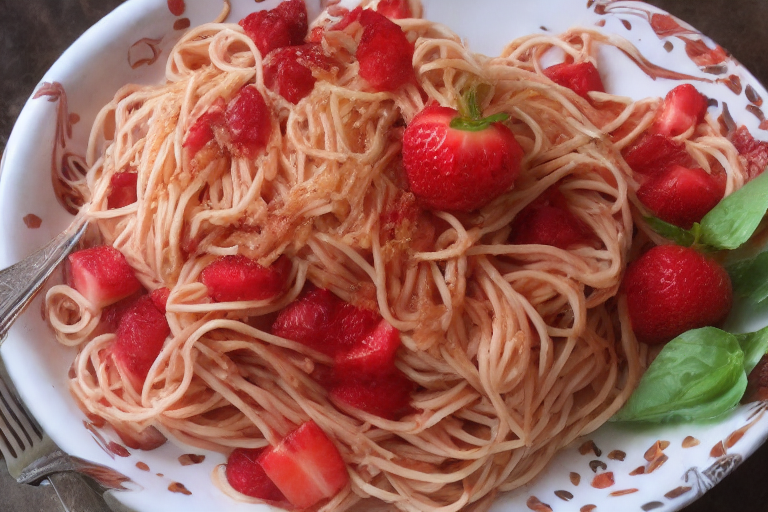

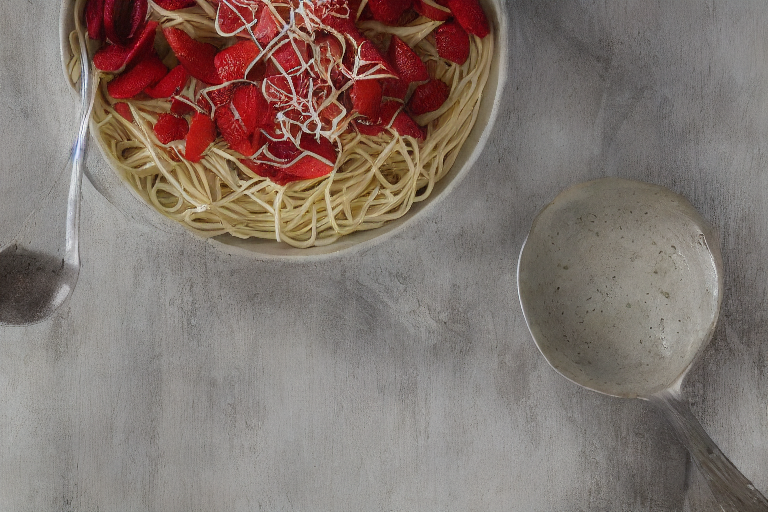

In [16]:
num_samples = 2
grid_rows = 1
grid_columns = 2

assert num_samples == grid_rows * grid_columns, f"Grid resolution {grid_rows * grid_columns} must match the number of images: {num_samples}!"

# Similar prompt used in Karpathy's stable diffusion gist, which motivated these scripts.
# https://gist.github.com/karpathy/00103b0037c5aaea32fe1da1af553355

prompt = ["strawberry spaghetti, light"] * num_samples

height = 512
width = 768

assert height % 8 == 0 and width % 8 == 0, f"Height and width should be multiples of 8, as per VAE downsapmling rate."

num_inference_steps = 50
guidance_scale = 3 # Classifier-free guidance scale.

# VAE applies x8 downsampling rate
init_latent = torch.randn((num_samples, pipe.unet.config.in_channels, height // 8, width // 8), device=torch_device)

with autocast(torch_device):
    # HuggingFace does not disable caching forward pass results during inference by default
    # To increase inference speed and memory footpring we simpy do torch.no_grad()
    with torch.no_grad():
        images = pipe(
            prompt,
            num_inference_steps=num_inference_steps,
            latents=init_latent,
            guidance_scale=guidance_scale
        )["images"]

for image in images:
    display(image)
    # uncomment to save images, without reproducibility medatada.
    # save_image(image)

### Visualizing the diffusion process

In [25]:
def decode(pipe, latent):
   image = pipe.vae.decode(latent / pipe.vae.config.scaling_factor).sample
   image = (image / 2 + 0.5).clamp(0, 1) # VAE decodes to [-1, 1] so convert to [0, 1]
   image = image.detach().cpu().permute(0, 2, 3, 1).numpy() # [B, C, H, W] => [B, H, W, C]
   image = (image[0] * 255).astype(np.uint8) # [Get color pixels]
   return Image.fromarray(image)
   # return image
 
prompt = "realistic strawberry spaghetti, light"
height = 512
width = 768
# Every frame_period-th frame will be included in the animation
frame_period = 5
images = []

assert height % 8 == 0 and width % 8 == 0, f"Height and width should be multiples of 8, as per VAE downsapmling rate."

num_inference_steps = 40
guidance_scale = 3 # Classifier-free guidance scale.

latent = torch.randn((1, pipe.unet.config.in_channels, height // 8, width // 8), device=torch_device)

# Depending on the scheduler, it might be necessary to scale the input noise.
# In particular, for EulerDiscreteScheduler, we would scale it by sigmas[0], first step of 
# approximating the reverse diffusion SDE.
if pipe.scheduler.init_noise_sigma is not None:
    latent = latent * pipe.scheduler.init_noise_sigma

pipe.scheduler.set_timesteps(num_inference_steps)

tokenized_prompt = pipe.tokenizer(prompt, padding="max_length", max_length=pipe.tokenizer.model_max_length, truncation=True, return_tensors="pt")
cond_embeddings = pipe.text_encoder(tokenized_prompt.input_ids.to(torch_device))[0] # shape [1, 77, 768]
# maximum sequence length is 77 tokens apparently for this version of CLIP
max_length = cond_embeddings.shape[1] # 77

tokenized_empty_prompt = pipe.tokenizer("", padding="max_length", max_length=max_length, return_tensors="pt")
uncond_embeddings = pipe.text_encoder(tokenized_empty_prompt.input_ids.to(torch_device))[0]
text_embeddings = torch.cat([uncond_embeddings, cond_embeddings])
mask = torch.cat([tokenized_empty_prompt.attention_mask, tokenized_prompt.attention_mask]).to(torch_device)

timesteps = pipe.scheduler.timesteps

with autocast(torch_device):
    with torch.no_grad():
        for i, t in tqdm(enumerate(pipe.scheduler.timesteps), total = len(timesteps)):
            # Recall EDM paper, some models might require input rescaling. Hugging face schedulers implement this.
            model_input = torch.cat([latent, latent])
            model_input = pipe.scheduler.scale_model_input(model_input, t)
        
            # Denoiser forward pass
            noise_pred = pipe.unet(model_input, t, encoder_hidden_states = text_embeddings).sample
            uncond_noise, cond_noise = noise_pred.chunk(2)
            # Classifier-free guidance formula
            noise = uncond_noise + guidance_scale * (cond_noise - uncond_noise)
            latent = pipe.scheduler.step(noise, t, latent).prev_sample

            if i % frame_period == 0 or i == len(timesteps) - 1:
                img = decode(pipe, latent)
                images.append(img)


# Creating a GIF file from saved diffusion steps
# How long will a single image last in the resulting GIF
single_image_duration_ms = 50
images[0].save("/kaggle/working/diffusion_animation.gif",
               save_all=True, append_images=images[1:], optimize=False, duration=single_image_duration_ms * len(images), loop=0)                

  0%|          | 0/40 [00:00<?, ?it/s]

Now you can visualize the diffusion process, using the created GIF.

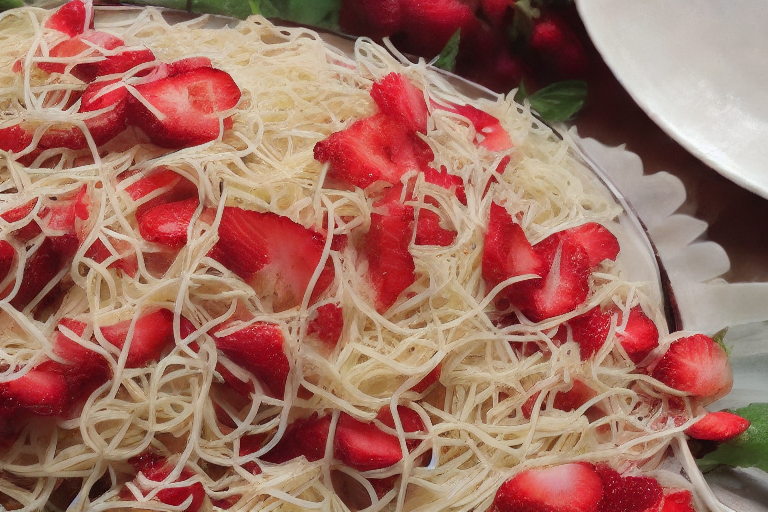

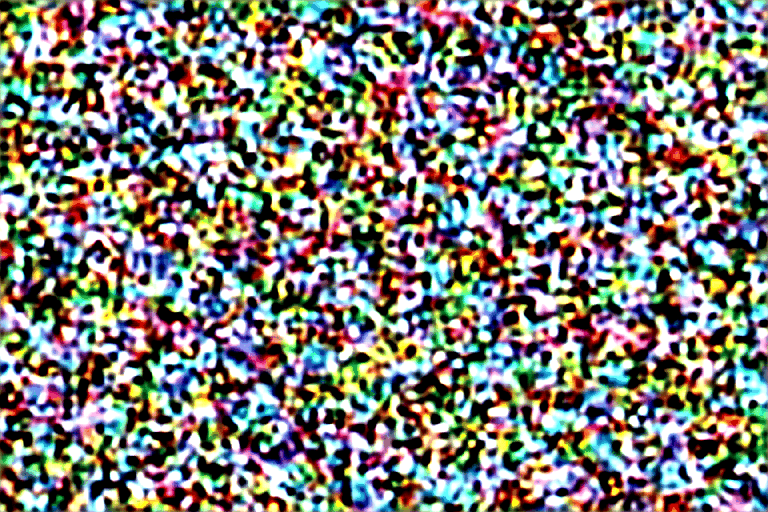

In [26]:
display(images[-1])
ipython_display.Image(data=open("/kaggle/working/diffusion_animation.gif",'rb').read(), format="png")

### Interpolation in the latent space
Consider a textual prompt $p$. As per usual, we start from appropriately scaled Gaussian noise $z$ in the latent space, apply the diffusion process, and feed the output of diffusion to the decoder to obtain an image $I$. For different initial latents $z_1, z_2$ matching the same prompt, we obtain different $I_1, I_2$. It turns out that you could perform interpolation in the latent space $i(z_1, z_2, x) = z'$, where $x$ are additional interpolation parameters (linear or spherical interpolation for example), feed $z'$ to the reverse diffusion process, and the output image can be interpreted as an interpolation between $I_1, I_2$. I did not implement this algorithm here, although using previous pieces of code it can be done fairly easily.